In [2]:
# Basics
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Sklearn
from sklearn.preprocessing import StandardScaler, Imputer 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.metrics import make_scorer
# xgboost
import xgboost as xgb
# Our custom modules
sys.path.append('..')
from anrg.pipeline import Pipeline, SelectTailK, LeaveTailK, SelectK2Last, DummyRegressor
from anrg.blending import BlendedRegressor
from anrg.cleaning import TargetThresholdFilter, LogPlusOne
from anrg.mp import MPRegressor
##### setting #######
pd.set_option('display.max_columns', 500)  # force pandas to display all columns for better visual inspection
%matplotlib inline

In [3]:
trn = pd.read_csv('../data/train.csv')
# trn = pd.read_csv('../data/train_10.csv', index_col=0)  # column #0 in our file is DataFrame index
# trn = pd.read_csv('../data/train_1.csv', index_col=0)

In [4]:
# Combine observations by 'Id', aggregate features
t = time.time()
trn_comb = trn.groupby('Id').agg(['mean','std','median','count', 'min', 'max'])
trn_comb.columns = ['_'.join(tup) for (i,tup) in enumerate(trn_comb.columns.values)]
# ignore id's where all Ref vales are NaN
trn_withRef_comb = trn_comb[pd.notnull(trn_comb.Ref_mean)]
# Timing
print 'Time elapsed: {:.4f} secs'.format(time.time()-t)  # toc

Time elapsed: 31.3604 secs


In [5]:
# Add deterministic estimator as columns
# MP params=0.82
trn_withRef_comb.loc[:,'MP'] = 1+pow(pow(10, trn_withRef_comb['Ref_mean']/10)/200, 0.625 * 0.82)
#KDP
kdp_aa, kdp_bb, kdp_aa_scaling, kdp_bb_scaling = 4.06, 0.0866, 0.33, 0.79
trn_withRef_comb.loc[:,'KDP'] = np.sign(trn_withRef_comb['Kdp_mean'])*(kdp_aa*kdp_aa_scaling)*pow(np.abs(trn_withRef_comb['Kdp_mean']),kdp_bb*kdp_bb_scaling)
#KDP_ZDR
kdpzdr_aa, kdpzdr_bb, kdpzdr_cc, kdpzdr_aa_scaling = 13.6, 0.0968, -0.286, 0.003
trn_withRef_comb.loc[:, 'KDP_ZDR'] = np.sign(trn_withRef_comb['Kdp_mean'])*(kdpzdr_aa*kdpzdr_aa_scaling)*pow(np.abs(trn_withRef_comb['Kdp_mean']),kdpzdr_bb)*pow(pow(10,trn_withRef_comb['Zdr_mean']/10),kdpzdr_cc)
#REF_ZDR
refzdr_aa, refzdr_bb, refzdr_cc, refzdr_aa_scaling, refzdr_bb_scaling, refzdr_cc_scaling = 0.00746, 0.945, -4.76, 0.0017, 0.9, 0.8
trn_withRef_comb.loc[:,'REF_ZDR'] = (refzdr_aa*refzdr_aa_scaling)*pow(pow(10,trn_withRef_comb['Ref_mean']/10),refzdr_bb*refzdr_bb_scaling)*pow(pow(10,trn_withRef_comb['Zdr_mean']/10),refzdr_cc*refzdr_cc_scaling)
# Regularizing negative predictions to 0
for name in ['MP','KDP', 'KDP_ZDR', 'REF_ZDR']:
    trn_withRef_comb.loc[trn_withRef_comb[name]<0, name] = 0
# Taking log(1+x) on all predictions
trn_withRef_comb.loc[:, ['MP','KDP', 'KDP_ZDR', 'REF_ZDR']] = np.log10(1+trn_withRef_comb.loc[:, ['MP','KDP', 'KDP_ZDR', 'REF_ZDR']])

/home/lewis/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/lewis/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:420: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [6]:
# Extract X and y
y = trn_withRef_comb['Expected_mean']
X = trn_withRef_comb.ix[:, [col for col in trn_withRef_comb.columns if not 'Expected' in col]]  # NOTE: used range slicing on column
print X.shape, y.shape

(731556, 136) (731556,)


In [14]:
ttf = TargetThresholdFilter(threshold=45)
lpo = LogPlusOne()
imp = Imputer(strategy='median', copy=False)  # Get a imputor with column-mean filling config
ss = StandardScaler(copy=False, with_mean=True, with_std=True)
base1 = Pipeline([('sel', LeaveTailK(K=4)), ('rf', RandomForestRegressor(n_estimators=500, max_features=0.2, max_depth=25, n_jobs=8))])  # NOTE: n_jobs=-1 will use all of your cores, set to a prefered number e.g. 4
base2 = Pipeline([('sel', LeaveTailK(K=4)), ('xgb', xgb.sklearn.XGBRegressor(n_estimators=500, nthread=8))], copy = False)
base3 = Pipeline([('sel', LeaveTailK(K=4)), ('ri', Ridge(alpha=2.0))], copy = False)
base4 = Pipeline([('sel', LeaveTailK(K=4)), ('la', Lasso(alpha=0.01))], copy = False)
base5 = Pipeline([('sel', SelectK2Last(K=4)), ('mp', DummyRegressor())], copy = False)
base6 = Pipeline([('sel', SelectK2Last(K=3)), ('kdp', DummyRegressor())], copy = False)
base7 = Pipeline([('sel', SelectK2Last(K=2)), ('kdp_zdr', DummyRegressor())], copy = False)
base8 = Pipeline([('sel', SelectK2Last(K=1)), ('ref_zdr', DummyRegressor())], copy = False)
blender = Ridge(alpha=1.3)
base_models=(base1, base2, base3, base4, base5, base6, base7, base8)
clf = BlendedRegressor(base_models=base_models, blending_model=blender, blending_split=0.2, with_feature=True)
pip = Pipeline([('ttf',ttf), ('lpo',lpo), ('imp',imp), ('ss',ss), ('clf',clf)], copy=True)  # a Pipeline wrapper to chain'em up
def LogPlusOne_score(ground_truth, predictions, lpo=lpo):
    tmp = np.abs(ground_truth - (np.power(10, predictions) - 1))
    idx = tmp.argmax()
#     print ground_truth[idx], predictions[idx], tmp[idx]
    return np.float64(np.mean(np.abs(ground_truth - (np.power(10, predictions) - 1))))
scorer = make_scorer(LogPlusOne_score, greater_is_better=False)  # define scoring metric

# CV

In [7]:
# base1 = Pipeline([('sel', LeaveTailK(K=4)), ('rf', RandomForestRegressor(n_estimators=500, max_features=0.2, max_depth=25, n_jobs=1))])  # NOTE: n_jobs=-1 will use all of your cores, set to a prefered number e.g. 4
# base2 = Pipeline([('sel', LeaveTailK(K=4)), ('xgb', xgb.sklearn.XGBRegressor(n_estimators=500, nthread=1))], copy = False)
# base3 = Pipeline([('sel', LeaveTailK(K=4)), ('ri', Ridge(alpha=2.0))], copy = False)
# base4 = Pipeline([('sel', LeaveTailK(K=4)), ('la', Lasso(alpha=0.01))], copy = False)
# base5 = Pipeline([('sel', SelectK2Last(K=4)), ('mp', DummyRegressor())], copy = False)
# base6 = Pipeline([('sel', SelectK2Last(K=3)), ('kdp', DummyRegressor())], copy = False)
# base7 = Pipeline([('sel', SelectK2Last(K=2)), ('kdp_zdr', DummyRegressor())], copy = False)
# base8 = Pipeline([('sel', SelectK2Last(K=1)), ('ref_zdr', DummyRegressor())], copy = False)
# blender = Ridge(alpha=1.65)
# base_models=(base1, base2, base3, base4, base5, base6, base7, base8)
# clf = BlendedRegressor(base_models=base_models, blending_model=blender, blending_split=0.2, with_feature=True)
scores = cross_val_score(estimator=pip, X=X, y=y, scoring=scorer, cv=10, n_jobs=1, verbose=3)
print np.mean(scores), np.std(scores)
print pip.get_params()['steps']

[Parallel(n_jobs=2)]: Done   1 jobs       | elapsed: 48.7min
[Parallel(n_jobs=2)]: Done   8 out of  10 | elapsed: 184.3min remaining: 46.1min
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed: 229.1min finished


-23.0795741293 1.5804091146
[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', BlendedRegressor(base_models=(Pipeline(copy=True,
     steps=[('sel', LeaveTailK(K=4)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=0.2, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimato...())]), Pipeline(copy=False,
     steps=[('sel', SelectK2Last(K=1)), ('ref_zdr', DummyRegressor())])),
         blending_model=Ridge(alpha=1.65, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001),
         blending_split=0.2, with_feature=True))]
[CV] no parameters to be set .........................................
[CV] no parameters to be set ........................

In [ ]:
# base1 = Pipeline([('sel', LeaveTailK(K=4)), ('rf', RandomForestRegressor(n_estimators=500, max_features=0.2, max_depth=25, n_jobs=15))])  # NOTE: n_jobs=-1 will use all of your cores, set to a prefered number e.g. 4
# base2 = Pipeline([('sel', LeaveTailK(K=4)), ('xgb', xgb.sklearn.XGBRegressor(n_estimators=500, nthread=15))], copy = False)
# base3 = Pipeline([('sel', LeaveTailK(K=4)), ('ri', Ridge(alpha=2.0))], copy = False)
# base4 = Pipeline([('sel', LeaveTailK(K=4)), ('la', Lasso(alpha=0.01))], copy = False)
# base5 = Pipeline([('sel', SelectK2Last(K=4)), ('mp', DummyRegressor())], copy = False)
# base6 = Pipeline([('sel', SelectK2Last(K=3)), ('kdp', DummyRegressor())], copy = False)
# base7 = Pipeline([('sel', SelectK2Last(K=2)), ('kdp_zdr', DummyRegressor())], copy = False)
# base8 = Pipeline([('sel', SelectK2Last(K=1)), ('ref_zdr', DummyRegressor())], copy = False)
# blender = Ridge(alpha=1.5)
# base_models=(base1, base2, base3, base4, base5, base6, base7, base8)
# clf = BlendedRegressor(base_models=base_models, blending_model=blender, blending_split=0.2, with_feature=True)
scores = cross_val_score(estimator=pip, X=X, y=y, scoring=scorer, cv=10, n_jobs=1, verbose=3)
print np.mean(scores), np.std(scores)
print pip.get_params()['steps']

[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-22.186725 -26.2min
[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-22.461286 -24.9min
[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-23.338106 -22.7min
[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-24.858143 -22.9min
[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-23.701660 -23.7min
[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-23.855486 -24.3min
[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-19.848321 -23.7min
[CV] n

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed: 26.2min
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 248.5min finished



-23.0795766156 1.5803032266
[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', BlendedRegressor(base_models=(Pipeline(copy=True,
     steps=[('sel', LeaveTailK(K=4)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=0.2, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimato...())]), Pipeline(copy=False,
     steps=[('sel', SelectK2Last(K=1)), ('ref_zdr', DummyRegressor())])),
         blending_model=Ridge(alpha=1.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001),
         blending_split=0.2, with_feature=True))]


In [13]:
# base1 = Pipeline([('sel', LeaveTailK(K=4)), ('rf', RandomForestRegressor(n_estimators=500, max_features=0.2, max_depth=25, n_jobs=8))])  # NOTE: n_jobs=-1 will use all of your cores, set to a prefered number e.g. 4
# base2 = Pipeline([('sel', LeaveTailK(K=4)), ('xgb', xgb.sklearn.XGBRegressor(n_estimators=500, nthread=8))], copy = False)
# base3 = Pipeline([('sel', LeaveTailK(K=4)), ('ri', Ridge(alpha=2.0))], copy = False)
# base4 = Pipeline([('sel', LeaveTailK(K=4)), ('la', Lasso(alpha=0.01))], copy = False)
# base5 = Pipeline([('sel', SelectK2Last(K=4)), ('mp', DummyRegressor())], copy = False)
# base6 = Pipeline([('sel', SelectK2Last(K=3)), ('kdp', DummyRegressor())], copy = False)
# base7 = Pipeline([('sel', SelectK2Last(K=2)), ('kdp_zdr', DummyRegressor())], copy = False)
# base8 = Pipeline([('sel', SelectK2Last(K=1)), ('ref_zdr', DummyRegressor())], copy = False)
# blender = Ridge(alpha=1.45)
# base_models=(base1, base2, base3, base4, base5, base6, base7, base8)
# clf = BlendedRegressor(base_models=base_models, blending_model=blender, blending_split=0.2, with_feature=True)
scores = cross_val_score(estimator=pip, X=X, y=y, scoring=scorer, cv=10, n_jobs=1, verbose=3)
print np.mean(scores), np.std(scores)
print pip.get_params()['steps']

[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-22.187918 -33.5min
[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-22.461285 -32.1min
[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-23.335912 -33.1min
[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-24.858724 -33.3min
[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-23.699802 -33.6min
[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-23.855560 -32.9min
[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-19.846922 -32.8min
[CV] n

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed: 33.5min
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 328.1min finished



-23.0791870298 1.58047503911
[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', BlendedRegressor(base_models=(Pipeline(copy=True,
     steps=[('sel', LeaveTailK(K=4)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=0.2, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimato...())]), Pipeline(copy=False,
     steps=[('sel', SelectK2Last(K=1)), ('ref_zdr', DummyRegressor())])),
         blending_model=Ridge(alpha=1.45, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001),
         blending_split=0.2, with_feature=True))]


In [15]:
# base1 = Pipeline([('sel', LeaveTailK(K=4)), ('rf', RandomForestRegressor(n_estimators=500, max_features=0.2, max_depth=25, n_jobs=8))])  # NOTE: n_jobs=-1 will use all of your cores, set to a prefered number e.g. 4
# base2 = Pipeline([('sel', LeaveTailK(K=4)), ('xgb', xgb.sklearn.XGBRegressor(n_estimators=500, nthread=8))], copy = False)
# base3 = Pipeline([('sel', LeaveTailK(K=4)), ('ri', Ridge(alpha=2.0))], copy = False)
# base4 = Pipeline([('sel', LeaveTailK(K=4)), ('la', Lasso(alpha=0.01))], copy = False)
# base5 = Pipeline([('sel', SelectK2Last(K=4)), ('mp', DummyRegressor())], copy = False)
# base6 = Pipeline([('sel', SelectK2Last(K=3)), ('kdp', DummyRegressor())], copy = False)
# base7 = Pipeline([('sel', SelectK2Last(K=2)), ('kdp_zdr', DummyRegressor())], copy = False)
# base8 = Pipeline([('sel', SelectK2Last(K=1)), ('ref_zdr', DummyRegressor())], copy = False)
# blender = Ridge(alpha=1.3)
# base_models=(base1, base2, base3, base4, base5, base6, base7, base8)
# clf = BlendedRegressor(base_models=base_models, blending_model=blender, blending_split=0.2, with_feature=True)
scores = cross_val_score(estimator=pip, X=X, y=y, scoring=scorer, cv=10, n_jobs=1, verbose=3)
print np.mean(scores), np.std(scores)
print pip.get_params()['steps']

[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-22.189119 -32.8min
[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-22.462491 -32.4min
[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-23.337383 -30.9min
[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-24.860385 -30.8min
[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-23.699989 -32.4min
[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-23.857302 -31.9min
[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-19.849174 -31.5min
[CV] n

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed: 32.8min
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 318.9min finished



-23.0802470572 1.58035611458
[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', BlendedRegressor(base_models=(Pipeline(copy=True,
     steps=[('sel', LeaveTailK(K=4)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=0.2, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimato...())]), Pipeline(copy=False,
     steps=[('sel', SelectK2Last(K=1)), ('ref_zdr', DummyRegressor())])),
         blending_model=Ridge(alpha=1.3, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001),
         blending_split=0.2, with_feature=True))]


In [119]:
# Sweep parameter
param_name, param_range='clf__blending_split', [0.25, 0.3, 0.35, 0.4]
train_scores, test_scores= validation_curve(estimator=pip, X=X, y=y, scoring=scorer, cv=10, n_jobs=1, 
                          param_name=param_name, param_range=param_range, verbose=3)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)# Sweep parameter

[CV] clf__blending_split=0.25 ........................................
[CV] ............. clf__blending_split=0.25, score=-18.713007 -   6.8s
[CV] clf__blending_split=0.3 .........................................
[CV] .............. clf__blending_split=0.3, score=-18.707754 -   5.9s
[CV] clf__blending_split=0.35 ........................................
[CV] ............. clf__blending_split=0.35, score=-18.709316 -   6.2s
[CV] clf__blending_split=0.4 .........................................
[CV] .............. clf__blending_split=0.4, score=-18.702015 -   5.7s
[CV] clf__blending_split=0.25 ........................................
[CV] ............. clf__blending_split=0.25, score=-14.465574 -   6.8s
[CV] clf__blending_split=0.3 .........................................
[CV] .............. clf__blending_split=0.3, score=-14.467973 -   6.4s
[CV] clf__blending_split=0.35 ........................................
[CV] ............. clf__blending_split=0.35, score=-14.463040 -   6.1s
[CV] c

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:  3.2min
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  4.2min finished


[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', BlendedRegressor(base_models=(Pipeline(copy=True,
     steps=[('sel', LeaveTailK(K=4)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=0.2, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimato...())]), Pipeline(copy=False,
     steps=[('sel', SelectK2Last(K=1)), ('ref_zdr', DummyRegressor())])),
         blending_model=Ridge(alpha=1.65, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
         blending_split=0.25, with_feature=True))]
[0.1, 0.15, 0.2, 0.25]
[-16.74958162 -16.76306871 -16.77763937 -16.78406594]
[-16.9396585  -16.9337939  -16.9337067  -16.92897006]


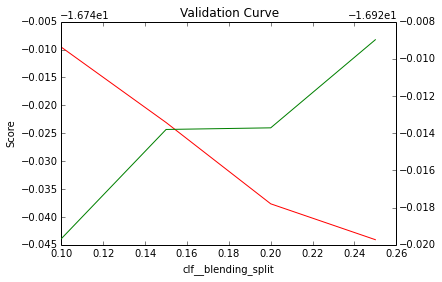

In [118]:
# Plotting the validation curver, i.e. trn/val error versus parameter value
# 8 estimators, 10 trees
# Sweep blending split = [0.1, 0.15, 0.2, 0.25]
# 1% data
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
plt.twinx()
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
plt.show()

[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', BlendedRegressor(base_models=(Pipeline(copy=True,
     steps=[('sel', LeaveTailK(K=4)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=0.2, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimato...())]), Pipeline(copy=False,
     steps=[('sel', SelectK2Last(K=1)), ('ref_zdr', DummyRegressor())])),
         blending_model=Ridge(alpha=1.65, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
         blending_split=0.4, with_feature=True))]
[0.25, 0.3, 0.35, 0.4]
[-16.79147303 -16.80095489 -16.80341789 -16.82215892]
[-16.9295884  -16.92902143 -16.9279248  -16.92751029]


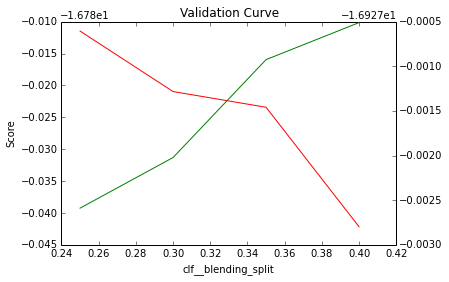

In [120]:
# Plotting the validation curver, i.e. trn/val error versus parameter value
# 8 estimators, 10 trees
# Sweep blending split = [0.25, 0.3, 0.35, 0.4]
# 1% data
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
plt.twinx()
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
plt.show()

[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', BlendedRegressor(base_models=(Pipeline(copy=True,
     steps=[('sel', LeaveTailK(K=4)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=0.2, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimato...())]), Pipeline(copy=False,
     steps=[('sel', SelectK2Last(K=1)), ('ref_zdr', DummyRegressor())])),
         blending_model=Ridge(alpha=2.25, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
         blending_split=0.2, with_feature=True))]
[ 0.5   0.75  1.    1.25  1.5   1.75  2.    2.25]
[-16.82281888 -16.81913688 -16.82479604 -16.80673112 -16.80236744
 -16.82670639 -16

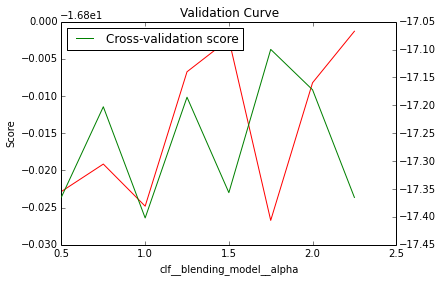

In [11]:
# Plotting the validation curver, i.e. trn/val error versus parameter value
# 8 estimators
# Sweep alpha = np.arange(0.5, 2.5, 0.25)
# 1% data
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.twinx()
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', BlendedRegressor(base_models=(Pipeline(copy=True,
     steps=[('sel', LeaveTailK(K=4)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=0.2, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimato...False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])),
         blending_model=Ridge(alpha=2.25, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
         blending_split=0.2, with_feature=True))]
[ 0.5   0.75  1.    1.25  1.5   1.75  2.    2.25]
[-16.8426178  -16.83108931 -16.82697228 -16.81933673 -16.81505369
 -16.81726312 -16

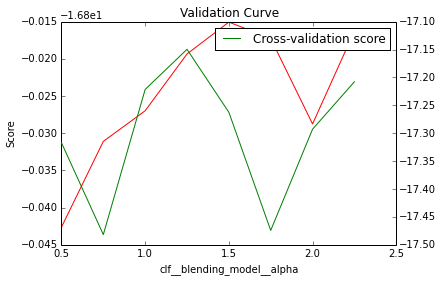

In [16]:
# Plotting the validation curver, i.e. trn/val error versus parameter value
# 4 estimators
# Sweep alpha = np.arange(0.5, 2.5, 0.25)
# 1% data
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.twinx()
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', BlendedRegressor(base_models=(Pipeline(copy=True,
     steps=[('sel', LeaveTailK(K=4)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=0.2, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimato...())]), Pipeline(copy=False,
     steps=[('sel', SelectK2Last(K=1)), ('ref_zdr', DummyRegressor())])),
         blending_model=Ridge(alpha=1.9500000000000004, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001),
         blending_split=0.2, with_feature=True))]
[ 1.5   1.55  1.6   1.65  1.7   1.75  1.8   1.85  1.9   1.95]
[-16.83115632 -16.80850813 -16.80891487 -16.81737217 -

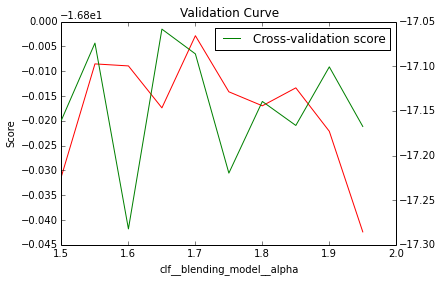

In [13]:
# Plotting the validation curver, i.e. trn/val error versus parameter value
# 8 estimators
# Sweep alpha = np.arange(1.5, 2, 0.05)
# 1% data
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.twinx()
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

# Generate submission

In [9]:
pip.fit(X, y)

Pipeline(copy=True,
     steps=[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', BlendedRegressor(base_models=(Pipeline(copy=True,
     ...ne,
   normalize=False, solver='auto', tol=0.001),
         blending_split=0.2, with_feature=True))])

In [10]:
test = pd.read_csv('../data/test.csv')
test_comb = test.groupby('Id').agg(['mean','std','median','count','min', 'max'])
test_comb.columns = ['_'.join(tup) for (i,tup) in enumerate(test_comb.columns.values)]
test_withRef_comb = test_comb[pd.notnull(test_comb.Ref_mean)]
# Add deterministic estimator as columns
# MP params=0.82
test_withRef_comb.loc[:,'MP'] = 1+pow(pow(10, test_withRef_comb['Ref_mean']/10)/200, 0.625 * 0.82)
#KDP
kdp_aa, kdp_bb, kdp_aa_scaling, kdp_bb_scaling = 4.06, 0.0866, 0.33, 0.79
test_withRef_comb.loc[:,'KDP'] = np.sign(test_withRef_comb['Kdp_mean'])*(kdp_aa*kdp_aa_scaling)*pow(np.abs(test_withRef_comb['Kdp_mean']),kdp_bb*kdp_bb_scaling)
#KDP_ZDR
kdpzdr_aa, kdpzdr_bb, kdpzdr_cc, kdpzdr_aa_scaling = 13.6, 0.0968, -0.286, 0.003
test_withRef_comb.loc[:, 'KDP_ZDR'] = np.sign(test_withRef_comb['Kdp_mean'])*(kdpzdr_aa*kdpzdr_aa_scaling)*pow(np.abs(test_withRef_comb['Kdp_mean']),kdpzdr_bb)*pow(pow(10,test_withRef_comb['Zdr_mean']/10),kdpzdr_cc)
#REF_ZDR
refzdr_aa, refzdr_bb, refzdr_cc, refzdr_aa_scaling, refzdr_bb_scaling, refzdr_cc_scaling = 0.00746, 0.945, -4.76, 0.0017, 0.9, 0.8
test_withRef_comb.loc[:,'REF_ZDR'] = (refzdr_aa*refzdr_aa_scaling)*pow(pow(10,test_withRef_comb['Ref_mean']/10),refzdr_bb*refzdr_bb_scaling)*pow(pow(10,test_withRef_comb['Zdr_mean']/10),refzdr_cc*refzdr_cc_scaling)
# Regularizing negative predictions to 0
for name in ['MP','KDP', 'KDP_ZDR', 'REF_ZDR']:
    test_withRef_comb.loc[test_withRef_comb[name]<0, name] = 0
# Taking log(1+x) on all predictions
test_withRef_comb.loc[:, ['MP','KDP', 'KDP_ZDR', 'REF_ZDR']] = np.log10(1+test_withRef_comb.loc[:, ['MP','KDP', 'KDP_ZDR', 'REF_ZDR']])
test_X = test_withRef_comb.ix[:, [col for col in test_withRef_comb.columns if not 'Expected' in col]]  # NOTE: used range slicing on column
print test_X.shape
test_y_predict = 10**pip.predict(X=test_X)-1

(426094, 136)


In [11]:
# Ref-samples
test_result_withRef = pd.DataFrame()
test_result_withRef['Id'] = test_withRef_comb.index
test_result_withRef['Expected'] = test_y_predict
# All-samples
test_result = pd.DataFrame()
test_result['Id'] = test['Id'].unique()
# Merge and set Non-Ref samples to -1
test_result = pd.merge(test_result, test_result_withRef, how='left', on=['Id'], sort=True)
test_result.loc[test_result['Expected'].isnull(), 'Expected'] = -1
# Write file
datetime_str = time.strftime('%Y%m%d_%H%M%S')
test_result.to_csv('../data/result_'+datetime_str+'.csv', index=False)
print '../data/result_'+datetime_str+'.csv'

../data/result_20151130_082222.csv
